#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the following ones contains the reconstructions each for each different encoding dimension tested.

Training set shape =  (50000, 784)


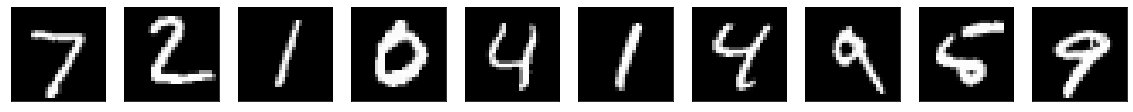

new training set shape =  (50000, 30)
training mse: 0.01818
test mse: 0.01771


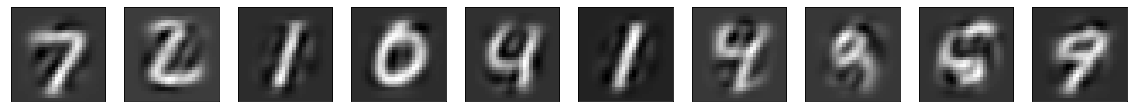

new training set shape =  (50000, 60)
training mse: 0.00994
test mse: 0.00967


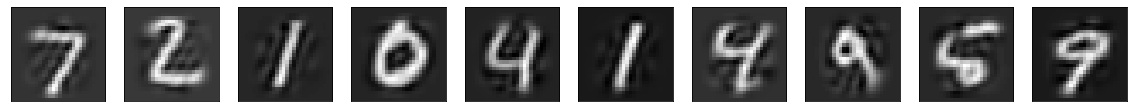

new training set shape =  (50000, 360)
training mse: 0.00048
test mse: 0.00047


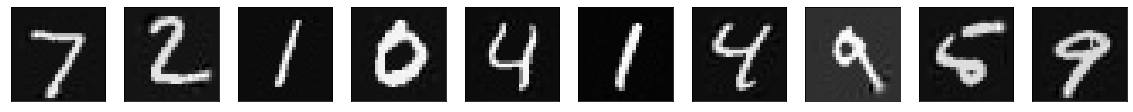

new training set shape =  (50000, 120)
training mse: 0.00464
test mse: 0.00455


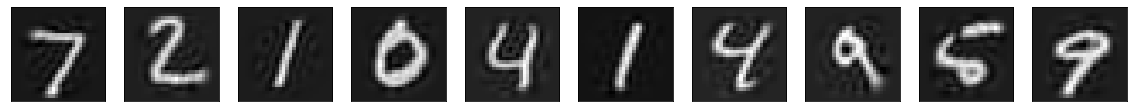

In [4]:
ENCODING_DIM = [30, 60, 360, 120]

def plot_img(n, input_data):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

print("Training set shape = ", np.shape(x_train))
plot_img(10, x_test)
N=len(ENCODING_DIM)
for i in range (N):
  U_k = svd_k(x_train, ENCODING_DIM[i])
  x_training_pca = np.dot(x_train, U_k)
  x_test_pca = np.dot(x_test, U_k)
  print("new training set shape = ", np.shape(x_training_pca))
  x_training_reco = np.dot(x_training_pca, U_k.T)
  x_test_reco = np.dot(x_test_pca, U_k.T)
  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()  
  print("training mse: %.5f" % (accuracy_train))
  print("test mse: %.5f" % (accuracy_test))
  plot_img(10, x_test_reco)

x_test_reco_svm_120 = x_test_reco

We can observe from the plots that as the encoding dimension is higher the less defined is the image, also with less color contrast. Test errors confirm the results are better as the encoding dimension is higher since it is lost less information.

## Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

Check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [5]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_19 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0837 - val_loss: 0.0145
Epoch 2/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0127 - val_loss: 0.0092
Epoch 3/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 9/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [6]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00477


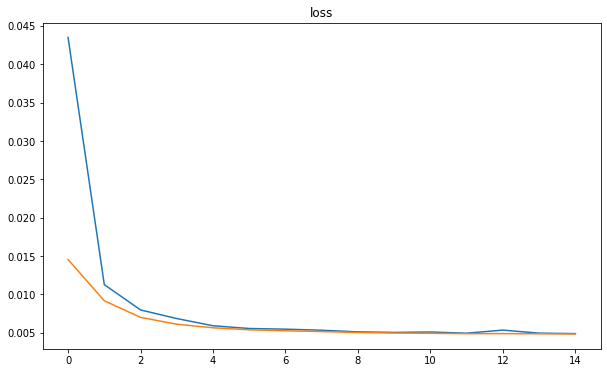

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

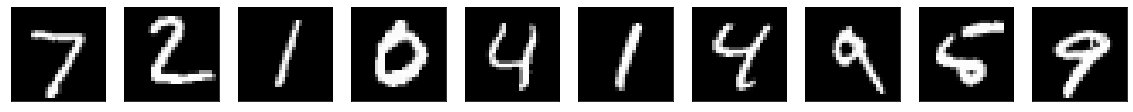

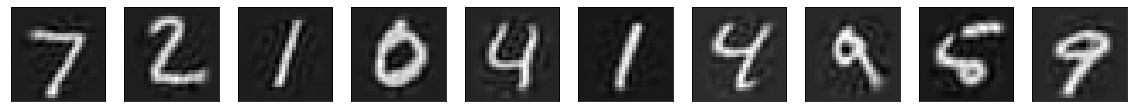

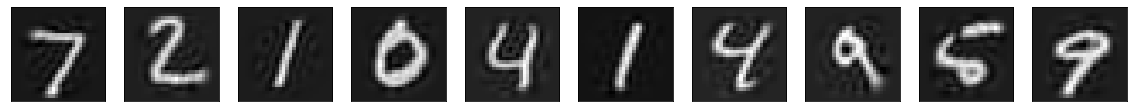

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs_lin = decoder.predict(encoded_imgs)

plot_img(10, x_test)
plot_img(10, decoded_imgs_lin)
plot_img(10, x_test_reco_svm_120)


Results and plots of SVM method and this shallow linear autoencoder look very similar in the case of same encodinng dimension. More precisely, exists a small difference between errors on test set, the first method obtained 0.0047, instead the second one 0.0051. This happens because shallow linear autoencoder is basically the same of an SVM since it linearly maps a datapoint to a low-dimensional latent space, applies a linear activation function, and projects the result back to the original high-dimensional space so as to minimize reconstruction error. If this is the  l2  norm, the functionality is essentially what an SVD already does. 

##Exercise 5.3: Shallow non-linear autoencoders
Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


In [ ]:
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 14ms/step - loss: 0.0759 - val_loss: 0.0355
Epoch 2/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0318 - val_loss: 0.0224
Epoch 3/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0208 - val_loss: 0.0162
Epoch 4/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 5/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0121 - val_loss: 0.0105
Epoch 6/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 7/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 8/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 11/

313/313 - 0s - loss: 0.0043
test mse: 0.00432


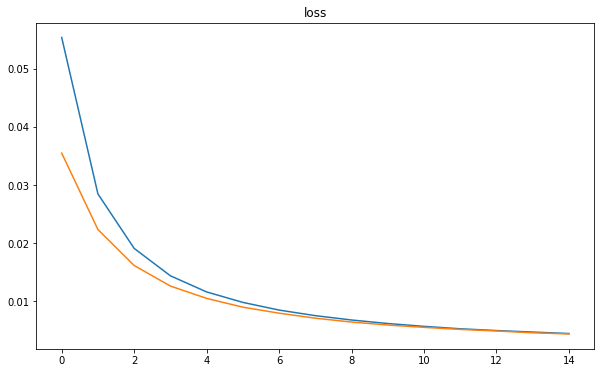

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))


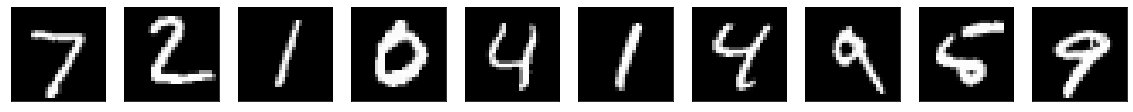

Non linear model decoded images: 


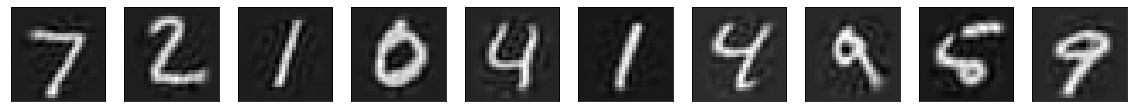

Linear model decoded images: 


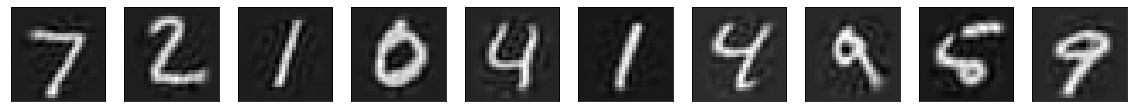

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, x_test)
print("Non linear model decoded images: ")
plot_img(10, decoded_imgs)
print("Linear model decoded images: ")
plot_img(10, decoded_imgs_lin)

I chose sigmoid activation function for both input and output layers. This function makes iutput values bound between 0 and 1, normalizing the output of each neuron. Also it tends to bring the output value to the edge of the curve, very close to 1 or 0, and this seems to be profitable for both layers. This enables more detailed output images, i.e. an higher variability, it can be easily observed comparing the two last plots.

##Exercise 5.4: Deep Autoencoder
Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
ENCODING_DIM = 32

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(120, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(60, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(encoded)

#...and the decoder...
decoded = tf.keras.layers.Dense(60, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(120, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-3]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_21 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1952      
_________________________________________________________________
dense_23 (Dense)             (None, 60)                1980      
_________________________________________________________________
dense_24 (Dense)             (None, 120)               7320      
_________________________________________________________________
dense_25 (Dense)             (None, 784)               948

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 5112, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
10/10 [==============================] - 2s 138ms/step - loss: 0.1619 - val_loss: 0.0871
Epoch 2/15
10/10 [==============================] - 1s 124ms/step - loss: 0.0818 - val_loss: 0.0703
Epoch 3/15
10/10 [==============================] - 1s 121ms/step - loss: 0.0686 - val_loss: 0.0630
Epoch 4/15
10/10 [==============================] - 1s 123ms/step - loss: 0.0620 - val_loss: 0.0585
Epoch 5/15
10/10 [==============================] - 1s 121ms/step - loss: 0.0574 - val_loss: 0.0538
Epoch 6/15
10/10 [==============================] - 1s 121ms/step - loss: 0.0529 - val_loss: 0.0500
Epoch 7/15
10/10 [==============================] - 1s 127ms/step - loss: 0.0491 - val_loss: 0.0450
Epoch 8/15
10/10 [==============================] - 1s 127ms/step - loss: 0.0447 - val_loss: 0.0425
Epoch 9/15
10/10 [==============================] - 1s 127ms/step - loss: 0.0425 - val_loss: 0.0403
Epoch 10/15
10/10 [==============================] - 1s 129ms/step - loss: 0.0399 - val_loss: 0.0378

313/313 - 0s - loss: 0.0317
test mse: 0.03172


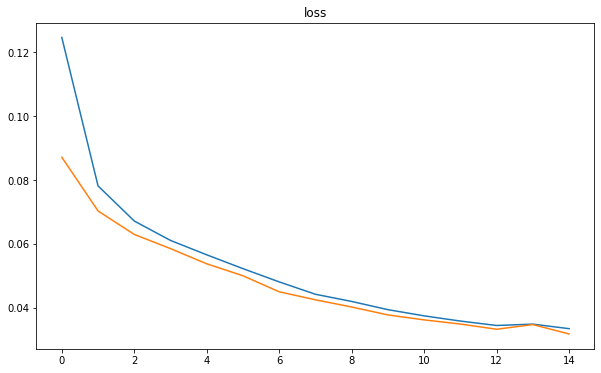

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

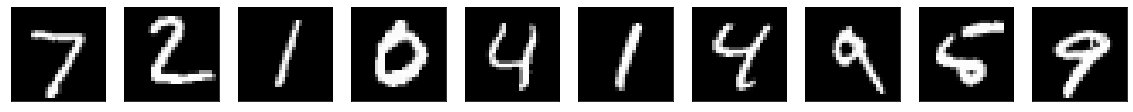

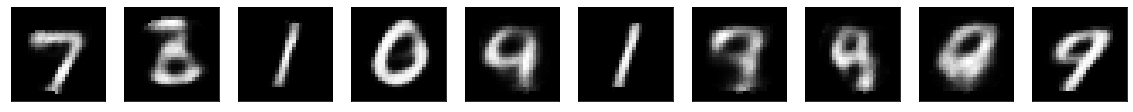

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test)
plot_img(10, decoded_imgs)


##Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

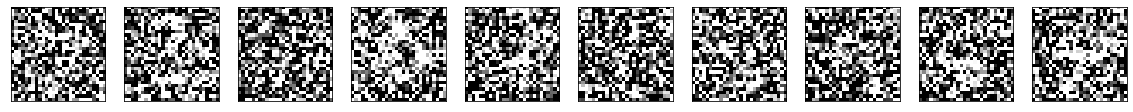

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_29 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 15ms/step - loss: 0.6960 - val_loss: 0.0927
Epoch 2/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0834 - val_loss: 0.0631
Epoch 3/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0593 - val_loss: 0.0513
Epoch 4/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0495 - val_loss: 0.0462
Epoch 5/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0453 - val_loss: 0.0436
Epoch 6/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0433 - val_loss: 0.0421
Epoch 7/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0418 - val_loss: 0.0414
Epoch 8/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0409 - val_loss: 0.0407
Epoch 9/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0402 - val_loss: 0.0403
Epoch 10/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0399 - val_loss: 0.0399
Epoch 11/

313/313 - 0s - loss: 0.0391
test mse: 0.03909


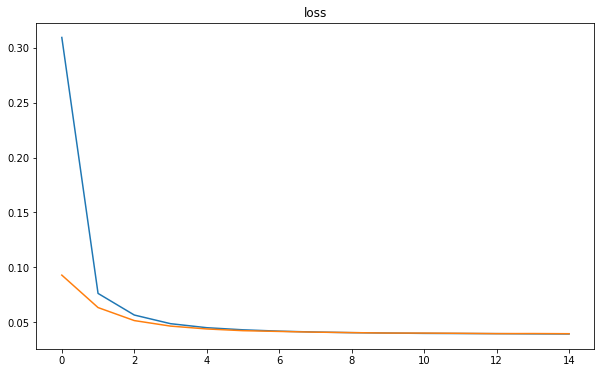

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the corresponding denoised outputs.

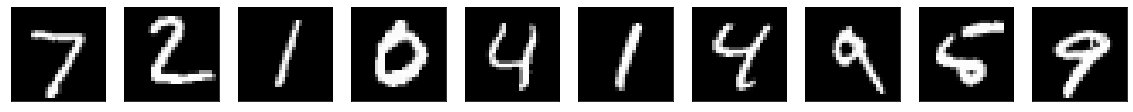

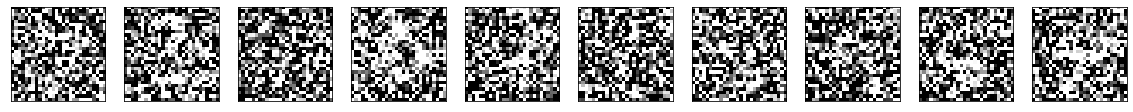

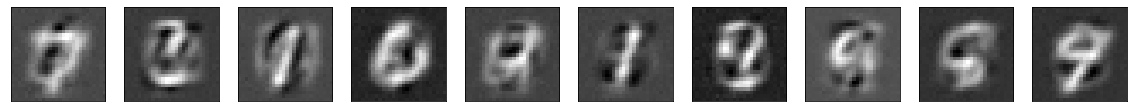

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test)
plot_img(10, x_test_noisy)
plot_img(10, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 59ms/step - loss: 0.2638 - categorical_accuracy: 0.0704 - val_loss: 0.0742 - val_categorical_accuracy: 0.4066
Epoch 2/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0679 - categorical_accuracy: 0.4339 - val_loss: 0.0603 - val_categorical_accuracy: 0.4793
Epoch 3/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0574 - categorical_accuracy: 0.4985 - val_loss: 0.0527 - val_categorical_accuracy: 0.5344
Epoch 4/50
79/79 [==============================] - 4s 54ms/step - loss: 0.0514 - categorical_accuracy: 0.5419 - val_loss: 0.0466 - val_categorical_accuracy: 0.5629
Epoch 5/50
79/79 [==============================] - 4s 54ms/step - loss: 0.0444 - categorical_accuracy: 0.5782 - val_loss: 0.0417 - val_categorical_accuracy: 0.5902
Epoch 6/50
79/79 [==============================] - 4s 54ms/step - loss: 0.0402 - categorical_accuracy: 0.6289 - val_loss: 0.0370 - val_categorical_accuracy: 0.6407
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0086 - categorical_accuracy: 0.9499
categorical_accuracy: 94.99%


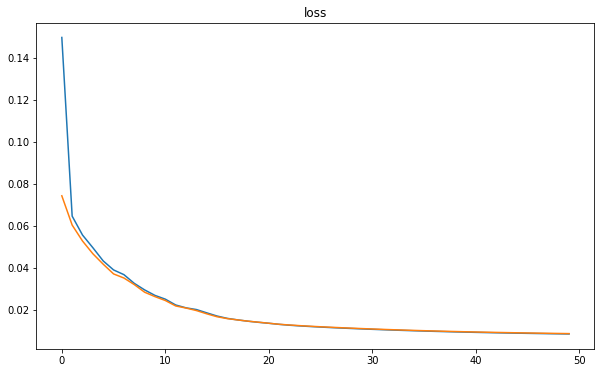

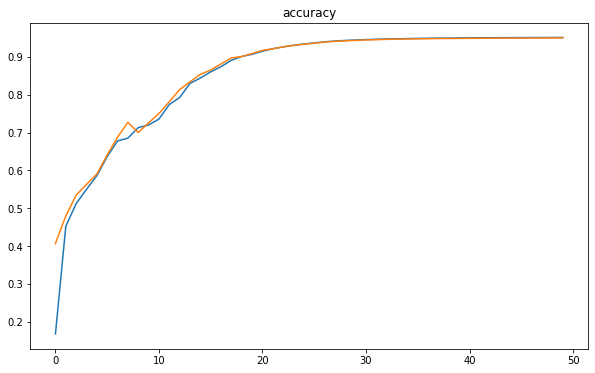

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time movie that <oov> the <oov> is <oov> a good <oov> film in just about <oov> <oov> <oov> <oov> all some the <oov> have <oov> out it <oov> people <oov> <oov> of the film are <oov> <oov> there <oov> movie <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> at <oov>


##Exercise 5.7: Non-Linear Autoencoder for sequences
Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='softmax')(inputs)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 100ms/step - loss: 0.0476 - categorical_accuracy: 0.3495 - val_loss: 0.0371 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 8s 99ms/step - loss: 0.0364 - categorical_accuracy: 0.4711 - val_loss: 0.0360 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0352 - categorical_accuracy: 0.4716 - val_loss: 0.0339 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 8s 100ms/step - loss: 0.0326 - categorical_accuracy: 0.4717 - val_loss: 0.0303 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 8s 100ms/step - loss: 0.0288 - categorical_accuracy: 0.4714 - val_loss: 0.0258 - val_categorical_accuracy: 0.4992
Epoch 6/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0242 - categorical_accuracy: 0.5578 - val_loss: 0.0209 - val_categorical_accuracy: 0.6965
Epoch

40/40 - 1s - loss: 0.0561 - categorical_accuracy: 0.0000e+00
categorical_accuracy: 0.00%


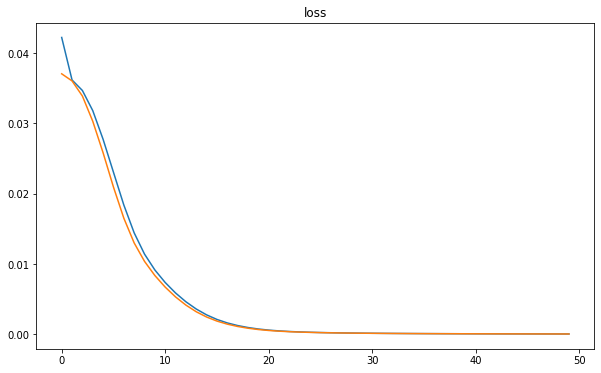

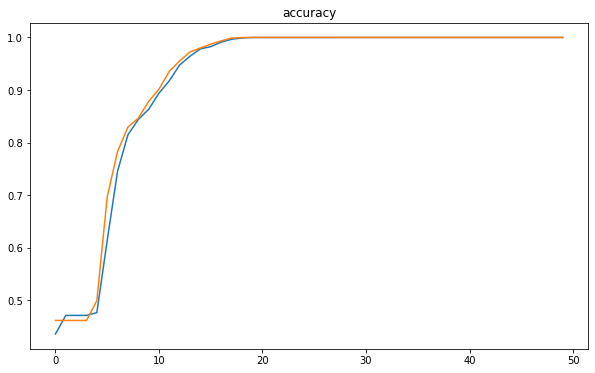

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
will than than than than than than than than will than than than than than than than than than than than than than than will than than than than than than than than than than than than than than than than than will than than than than than than than than than than than than than than than than than than than than than than than than than than than than will than than will than than than than than than than will than than than than than than than


The use of the LSTM layer and of the non-linear activation functions seem to be the best performing model.
The activation function I chose for the dense layer is the Softmax in order to predict a probability distribution in the call sequence.
It is able to normalize the outputs for each class between 0 and 1, and divides by their sum. It is suitable for this problem since we have multiple number of words (as like multiple number of categories for classification problems) and since data are in form of a sequence thus elements are not a priori independent.